<a href="https://colab.research.google.com/github/lizhieffe/language_model/blob/main/Shakespeare_LM_v3_Causal_Mask_%2B_FFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Warning**

This model's performance is not good. Very likely this is due to the Causal mask uses the plain avg approach.

In [113]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
USE_GPU = True

BLOCK_SIZE = 96 # Context length: how many chars do we take to predict the next one?

# Setup GPU

In [115]:
if USE_GPU:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  assert device.type != 'cpu', "GPU is not available"
else:
  device = 'cpu'

print(device)

cuda:0


In [116]:
g_cpu = torch.Generator(device='cpu').manual_seed(2147483647) # for reproducibility
g_device = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility

# Util Functions

# Load data

In [117]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# read in all the words
text = open('input.txt', 'r').read()

text[:800]

--2023-10-02 02:17:01--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.8’

input.txt.8         100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2023-10-02 02:17:01 (16.4 MB/s) - ‘input.txt.8’ saved [1115394/1115394]



"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to p"

In [118]:
print(f'total char # = {len(text)}')

total char # = 1115394


# Build vocabulary

In [119]:
chars = sorted(list(set(''.join(text))))

stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for c,i in stoi.items()}

assert len(stoi) == len(itos)

vocab_size = len(stoi)

EXPECTED_VOCAB_SIZE = 65
assert vocab_size == EXPECTED_VOCAB_SIZE, f"expected vocab size = {EXPECTED_VOCAB_SIZE}, got {vocab_size}"

In [120]:
# str ---> list of integer
encode = lambda str: [stoi[s] for s in str]

# list of integer ---> str
decode = lambda l: ''.join(itos[i] for i in l)

_test_str = "adb dfd \n"
assert _test_str == decode(encode(_test_str))

# Create DS

In [121]:
n1 = int(len(text) * 0.9)
train_data = encode(text[:n1])
dev_data = encode(text[n1:])

print(f'{len(train_data)=}, {len(dev_data)=}')

len(train_data)=1003854, len(dev_data)=111540


In [122]:
def get_batch(data, batch_size: int, block_size: int):
  """ Sample a batch using Causal style. """
  x_list = []
  y_list = []
  ix = torch.randint(0, len(data)-block_size, (batch_size,), generator=g_cpu)
  X = torch.stack([torch.tensor(data[i:i+block_size]) for i in ix]).to(device)
  Y = torch.stack([torch.tensor(data[i+1:i+1+block_size]) for i in ix]).to(device)
  return X, Y

In [123]:
X, Y = get_batch(train_data, 16, BLOCK_SIZE)

for b in range(3):
  it = 0
  for t in range(X.shape[1]):
    print(f'{decode(X[b, :t+1].tolist())} ---> {decode([Y[b, t].item()])}')
    it += 1
    if it > 7:
      break

e ---> v
ev ---> e
eve ---> r
ever ---> y
every --->  
every  ---> d
every d ---> a
every da ---> n
e ---> s
es ---> h
esh --->  
esh  ---> c
esh c ---> o
esh co ---> m
esh com ---> p
esh comp ---> l
e --->  
e  ---> r
e r ---> e
e re ---> t
e ret ---> i
e reti ---> r
e retir ---> e
e retire ---> d


# Modeling

In [124]:
n_embd = 768 # the dimensionality of the character embedding vectors
N_HIDDEN = n_embd * 4 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

## Model class

In [139]:
class Net(torch.nn.Module):

  def __init__(self, vocab_size, d_embd, d_hidden):
    """
    Args:
      vocab_size: volabulary size
      d_embd: dim of embedding for the token
      d_hidden: dim of hidden FFN layers
    """
    super().__init__()
    self.embd = torch.nn.Embedding(
        num_embeddings=vocab_size,
        embedding_dim=d_embd
    )

    self.linear1 = torch.nn.Linear(d_embd, d_hidden, bias=True)
    self.tanh1 = torch.nn.Tanh()
    self.linear2 = torch.nn.Linear(d_hidden, d_hidden, bias=True)
    self.tanh2 = torch.nn.Tanh()
    self.linear3 = torch.nn.Linear(d_hidden, d_hidden, bias=True)
    self.tanh3 = torch.nn.Tanh()
    self.linear_logit = torch.nn.Linear(d_hidden, vocab_size, bias=True)


  def forward(self, x, targets=None):
    """
    Args:
      x: (B, T). The input to the model.
      targets: (B, T). When it is not None, the func calculates and return the
        loss in additional to other returned item(s)
    Returns:
      loss: int
      logits: (B, T, C)
    """

    T = x.shape[-1]

    tril = torch.tril(torch.ones(T, T)).to(device)
    wei = tril / torch.sum(tril, dim=1, keepdim=True) # (T, T)

    xemb = self.embd(x) # (B, T, C)
    xemb = wei @ xemb  # (B, T, C)

    y = self.linear1(xemb)  # (B, T, d_hidden)
    y = self.tanh1(y)
    y = wei @ y # (B, T, d_hidden)

    y = self.linear2(y)  # (B, T, d_hidden)
    y = self.tanh2(y)
    y = wei @ y # (B, T, d_hidden)

    y = self.linear3(y)  # (B, T, d_hidden)
    y = self.tanh3(y)
    y = wei @ y # (B, T, d_hidden)

    logits = self.linear_logit(y) # (B, T, vocab_size)
    logits = wei @ logits # (B, T, vocab_size)
    logits = logits.view(-1, logits.shape[-1]) # (B, T, vocab_size)

    if targets is None:
      loss = None
    else:
      loss = F.cross_entropy(logits, targets.view(-1))

    return logits.view(-1, T, logits.shape[1]), loss

  def generate(self, idx, max_new_tokens: int):
    """Generate new tokens given idx as context.

    Args:
      idx: (B, T)
      max_new_tokens: number of new tokens to generate

    Returns:
      (B,T+max_new_tokens)
    """
    for _ in range(max_new_tokens):
      logits, loss = self(idx, targets=None)  # logits: (B, T, vocab_size), loss: None
      logits = logits[:, -1, :] # (B, vocab_size)
      prob = F.softmax(logits, dim=1) # (B, vocab_size)
      idx_next = torch.multinomial(prob, num_samples=1, replacement=False)  # (B, 1)
      idx = torch.cat((idx, idx_next), dim=1)

    return idx

net = Net(vocab_size, d_embd=n_embd, d_hidden=N_HIDDEN).to(device)

In [140]:
_total_params = 0

for p in net.parameters():
  _total_params += p.nelement()

print(f'Total params = {_total_params}')

Total params = 21492545


## Define optimizer

In [141]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train

In [142]:
max_steps = 700000
batch_size = 32
lossi = []
lossi_dev = []
ud = []
log_interval = 200

running_loss = 0.0
running_loss_dev = 0.0
running_loss_steps = 0

for i in range(max_steps):

  # Forward
  Xb, Yb = get_batch(train_data, batch_size, BLOCK_SIZE)
  optimizer.zero_grad()
  logits, loss = net(Xb, targets=Yb)

  # Loss
  # print(f'{outputs.shape=}, {Yb.shape=}')
  running_loss += loss.item()
  running_loss_steps += 1

  # Eval dev DS
  Xb_dev, Yb_dev = get_batch(dev_data, batch_size, BLOCK_SIZE)
  logits_dev, loss_dev = net(Xb_dev, targets=Yb_dev)
  running_loss_dev += loss_dev.item()

  # Update
  loss.backward()
  optimizer.step()

  # Track status
  if i % log_interval == 0:
    print(f'{i}/{max_steps}: training loss={running_loss/running_loss_steps:.4f}, dev loss={running_loss_dev/running_loss_steps:.4f}')
    running_loss = 0.0
    running_loss_dev = 0.0
    running_loss_steps = 0

  lossi.append(loss.log10().item())
  lossi_dev.append(loss_dev.log10().item())

0/700000: training loss=4.1836, dev loss=4.1785
200/700000: training loss=3.6789, dev loss=3.7059
400/700000: training loss=3.3609, dev loss=3.4004
600/700000: training loss=3.3346, dev loss=3.3787
800/700000: training loss=3.3196, dev loss=3.3641
1000/700000: training loss=3.3184, dev loss=3.3567
1200/700000: training loss=3.3167, dev loss=3.3553
1400/700000: training loss=3.3141, dev loss=3.3494
1600/700000: training loss=3.3109, dev loss=3.3537
1800/700000: training loss=3.3137, dev loss=3.3482
2000/700000: training loss=3.3080, dev loss=3.3504
2200/700000: training loss=3.3165, dev loss=3.3482
2400/700000: training loss=3.3156, dev loss=3.3426
2600/700000: training loss=3.3118, dev loss=3.3493
2800/700000: training loss=3.3119, dev loss=3.3488
3000/700000: training loss=3.3118, dev loss=3.3443
3200/700000: training loss=3.3070, dev loss=3.3488
3400/700000: training loss=3.3054, dev loss=3.3497
3600/700000: training loss=3.3133, dev loss=3.3457
3800/700000: training loss=3.3133, dev

KeyboardInterrupt: ignored

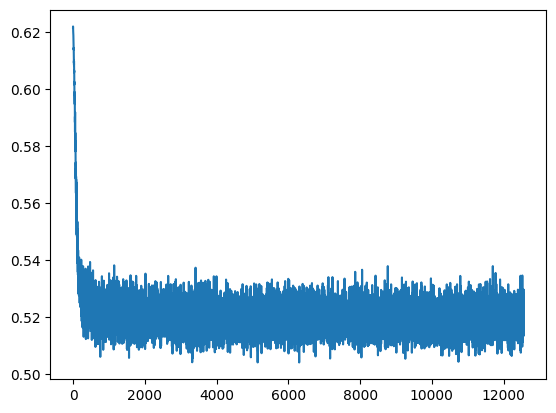

In [143]:
plt.plot(lossi)

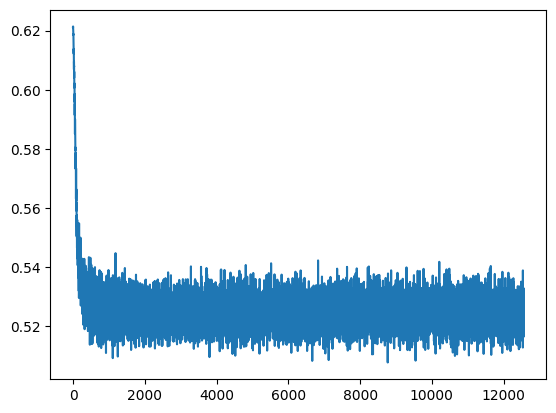

In [144]:
plt.plot(lossi_dev)

In [145]:
torch.cuda.empty_cache()

# Sample the model

In [146]:
g_gpu = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility

# 0, which is new line char, is a reasonable start (seed) char
idx = torch.tensor([[0]]).to(device)
new_idx = net.generate(idx, 1000)

print(decode(new_idx.view(-1).tolist()))



  Got ali:dlio,'
RBtedhS ey
!rrbtmraat hk
iu ta:  ?SihLYameGgrW   HAdO e dr  tdeohaStn:eooic wiahtyiniPtel' ;ueiQehaTicfeyI 
la wk ae
a  sd samwe hrI'ea Aim?cWhe .estw m,k hZAsciO eW
lcs :poeTrtdbe slbe oa dt d of tfne
s  ima eo ,Br o e 
ieo  t,C lsbbalC v 
l  h;e,esott.aEe ntulgiaecae i shrmirSry:ptnpam
 rfmDIeb o  odoron.eir t E:.iee
nscn 
od
inuds ssa uUUtr eCg dsnri eoiar:rebtas a olmurgI lns w cgkhawedlCht hutkAahsjya
Fiitrf u
oI sbt
tiautniberiaCeaUyan osrfwwh 
hsaN eirB i nMstUre  tt s tl piene aUfm
ra, :sdb tsh hho Ze  lhsarkRTe ny hio umdAeen
e
rya ni ounxd
EaS hrti, ahr o , ewh sSsbttL reIeeeadw . at a seko h
ouAmsnotRtrnatDi oSs  Tooyahi 
pwakoiseemot u
efer,igyred  aesitre,,hvwhe ef So E:n
anvlnEn  rste;ulynt iCt. V f
 drwadnAhdarn'lpea!yiaewprsIuaeEnDB YayenAaa,aem 
be  euRkfh  EARtmdws,aoneY sitt NH aUyoii' FpiUrt Ir Tiau:ie nb:C  ir t'evhsniad
 h oh,ue  r vvno'dEe,et  llancsm n,ycimktPo sda
 eewmhh mpaehdleg ifald  
 r
i:atlmiklsO
oof  ohmhsoh: fsohot e tahRriR  n Uo b